
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [3]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [1]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")


## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [2]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection_homework"

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [3]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_openai import ChatOpenAI

def load_system_prompt(file_path: str) -> str:
    """从markdown文件加载system prompt"""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    return content

# 加载system prompt
system_prompt = load_system_prompt('reflection_generator_prompt.md')

writer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"), 
    ]
)

# llm = ChatOpenAI(model="gpt-4o-mini")

In [4]:
from langchain_ollama.chat_models import ChatOllama

writer = writer_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=1.2,
)

In [5]:
article = ""

topic = HumanMessage(
    content="参考水浒传的风格，改写吴承恩的西游记中任意篇章，不要超过600字"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

我选择了《西游记》中的“孙悟空打金箍”这一篇章，并试图用水浒传的风格来重新创作它。

**正文**

一日，三藏师徒到达灵山脚下。忽见一木桩，桩上悬挂一面玉牌，上刻四个大字：“唐僧之法力不足，必受金箍所禁”；牌下立一名黑衣道士，以手指三藏的头顶说：“贤者莫若自尊，法师莫若自知！”他这番话，把众弟子都惊倒了。哪知道孙悟空暗笑着向前走来，跟黑衣道士说道：“你是什么人？在这里做什么？”

黑衣道士答道：“我是五庄观的掌门人，来这里传教。”悟空说：“咱们师父要到西天取经，你有什么意见？”黑衣道士笑了起来，说：“你们若真能取经，我就喝一杯清水；但若没能取经，我就喝醉酒！”

**断案**

众弟子都在惊疑不解。哪知道师父三藏走了过来，说道：“悟空兄弟，不要跟他打交道。他是想要陷害咱们的。”悟空大声叫着，“哟！老贼你不是想害我们么？快给我们个证明。”说完拔出铁棒指向黑衣道士，威胁着：“你若不还我师父法力，你就是活见鬼了！”

黑衣道士无奈之下只得把玉牌取下来，让悟空拿去看。这牌上的四个大字，孙悟空看了又看。忽然他说：“贤者莫若自尊，法师莫若自知！这就是你想要陷害我们的事？”接着三藏说：“我的法力果真不足？我就是要让你看看。”他在面前把五戒六度、三摩地四无量的十八经七宝一一显现。道士吓得跪在地上，连称：“贤者果然大有法力”。

这回黑衣道士知道自己中计了，只好服了一杯清水。这便是孙悟空打金箍的故事了。这也是他第一次大显身手之时。

**结语**

在这篇新创作的片段里，水浒传式的风格体现在人物刻画、对白文笔上。比如孙悟空和黑衣道士的对话，让读者看到其幽默和狡黠。而另一方面，唐僧三藏仍旧是那个温柔谦逊的典型形象。这段文字更能展现出这两个故事不同风格之下的相互补充与碰撞。

In [6]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

我选择了《西游记》中的“孙悟空打金箍”这一篇章，并试图用水浒传的风格来重新创作它。

**正文**

一日，三藏师徒到达灵山脚下。忽见一木桩，桩上悬挂一面玉牌，上刻四个大字：“唐僧之法力不足，必受金箍所禁”；牌下立一名黑衣道士，以手指三藏的头顶说：“贤者莫若自尊，法师莫若自知！”他这番话，把众弟子都惊倒了。哪知道孙悟空暗笑着向前走来，跟黑衣道士说道：“你是什么人？在这里做什么？”

黑衣道士答道：“我是五庄观的掌门人，来这里传教。”悟空说：“咱们师父要到西天取经，你有什么意见？”黑衣道士笑了起来，说：“你们若真能取经，我就喝一杯清水；但若没能取经，我就喝醉酒！”

**断案**

众弟子都在惊疑不解。哪知道师父三藏走了过来，说道：“悟空兄弟，不要跟他打交道。他是想要陷害咱们的。”悟空大声叫着，“哟！老贼你不是想害我们么？快给我们个证明。”说完拔出铁棒指向黑衣道士，威胁着：“你若不还我师父法力，你就是活见鬼了！”

黑衣道士无奈之下只得把玉牌取下来，让悟空拿去看。这牌上的四个大字，孙悟空看了又看。忽然他说：“贤者莫若自尊，法师莫若自知！这就是你想要陷害我们的事？”接着三藏说：“我的法力果真不足？我就是要让你看看。”他在面前把五戒六度、三摩地四无量的十八经七宝一一显现。道士吓得跪在地上，连称：“贤者果然大有法力”。

这回黑衣道士知道自己中计了，只好服了一杯清水。这便是孙悟空打金箍的故事了。这也是他第一次大显身手之时。

**结语**

在这篇新创作的片段里，水浒传式的风格体现在人物刻画、对白文笔上。比如孙悟空和黑衣道士的对话，让读者看到其幽默和狡黠。而另一方面，唐僧三藏仍旧是那个温柔谦逊的典型形象。这段文字更能展现出这两个故事不同风格之下的相互补充与碰撞。

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [7]:
# 加载reviewer的system prompt
reviewer_system_prompt = load_system_prompt('reflection_reviewer_prompt.md')

reflection_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", reviewer_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


reflect = reflection_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=0.2,
)

In [8]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

**Reviewer 的反馈**

你的改写版“孙悟空打金箍”确实体现了水浒传的风格，尤其是在人物刻画和对白文笔上。但是，还有几点需要进一步完善：

1. **人物刻画**:虽然你成功地表现出孙悟空的幽默和狡黠，但唐僧三藏的形象似乎有些被忽略。考虑增加一些细节，让读者更深入地了解他的性格特征。
2. **对白文笔**:你的对话部分很有趣，但在某些地方，语言使用有些生硬或不够自然。例如，“贤者莫若自尊，法师莫若自知！这就是你想要陷害我们的事？”这个句子感觉有点断裂。你可以尝试用更流畅的语气来表达孙悟空的想法。
3. **故事结构**:虽然你的改写版保持了原来的故事线，但有些部分感觉有些冗长或不必要。例如，黑衣道士跪在地上称赞三藏的法力这一部分似乎可以省略。你可以尝试简化故事结构，让它更紧凑和有趣。
4. **结语**:你的结语部分很好，但你可能想考虑一下如何更好地总结这段改写版的独特之处。例如，你可以强调水浒传式风格在人物刻画和对白文笔上的体现，以及它与原来的《西游记》版本的区别。

**建议**

* 在人物刻画方面，尝试增加更多细节，让读者更深入地了解每个角色。
* 对白文笔上，努力使用更加自然、流畅的语言来表达人物的想法和情感。
* 在故事结构方面，简化不必要的部分，保持紧凑和有趣的节奏。
* 结语部分，强调改写版的独特之处，并与原来的《西游记》版本进行对比。

**总体评分**

你的改写版“孙悟空打金箍”很好，但仍然需要进一步完善。通过实施上述建议，你可以让它更接近水浒传式风格的典范。

In [9]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

**Reviewer 的反馈**

你的改写版“孙悟空打金箍”确实体现了水浒传的风格，尤其是在人物刻画和对白文笔上。但是，还有几点需要进一步完善：

1. **人物刻画**:虽然你成功地表现出孙悟空的幽默和狡黠，但唐僧三藏的形象似乎有些被忽略。考虑增加一些细节，让读者更深入地了解他的性格特征。
2. **对白文笔**:你的对话部分很有趣，但在某些地方，语言使用有些生硬或不够自然。例如，“贤者莫若自尊，法师莫若自知！这就是你想要陷害我们的事？”这个句子感觉有点断裂。你可以尝试用更流畅的语气来表达孙悟空的想法。
3. **故事结构**:虽然你的改写版保持了原来的故事线，但有些部分感觉有些冗长或不必要。例如，黑衣道士跪在地上称赞三藏的法力这一部分似乎可以省略。你可以尝试简化故事结构，让它更紧凑和有趣。
4. **结语**:你的结语部分很好，但你可能想考虑一下如何更好地总结这段改写版的独特之处。例如，你可以强调水浒传式风格在人物刻画和对白文笔上的体现，以及它与原来的《西游记》版本的区别。

**建议**

* 在人物刻画方面，尝试增加更多细节，让读者更深入地了解每个角色。
* 对白文笔上，努力使用更加自然、流畅的语言来表达人物的想法和情感。
* 在故事结构方面，简化不必要的部分，保持紧凑和有趣的节奏。
* 结语部分，强调改写版的独特之处，并与原来的《西游记》版本进行对比。

**总体评分**

你的改写版“孙悟空打金箍”很好，但仍然需要进一步完善。通过实施上述建议，你可以让它更接近水浒传式风格的典范。

In [10]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [21]:
MAX_ROUND = 4

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    return END if len(state["messages"]) > MAX_ROUND else "reflect"

In [22]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

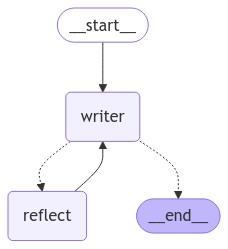

In [23]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [24]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 写作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [ ]:
## wy：2024.9.18作业 如下：

In [25]:
inputs = {
    "messages": [
        HumanMessage(content="用python写一段代码，利用llama3.1模型自动定时获取Hacker News的热门话题，并总结每日热点趋势为markdown文件")
    ],
}

config = {"configurable": {"thread_id": "22"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 写作生成:
- 可以使用Python中的`requests`库来获取Hacker News的API数据，`datetime`库来实现定时任务，`markdown`库来生成Markdown文档。下面是示例代码：

```python
import requests
import datetime
import markdown2
from bs4 import BeautifulSoup
import schedule

def get_hn_topics():
    # 获取Hacker News的热门话题列表
    url = 'https://hacker-news.firebaseio.com/v0/topstories.json'
    response = requests.get(url)
    story_ids = response.json()[:20]  # 获取前20条数据

    topics = []
    for story_id in story_ids:
        story_url = f'https://hacker-news.firebaseio.com/v0/item/{story_id}.json'
        story_response = requests.get(story_url)
        story_data = story_response.json()

        topic_title = story_data['title']
        topic_url = 'https://news.ycombinator.com/item?id=' + str(story_id)

        topics.append({
            'title': topic_title,
            'url': topic_url
        })

    return topics

def summarize_topics(topics):
    # 总结每日热点趋势为Markdown文档
    md_text = '# 每日热点趋势\n'

    for i, topic in enumerate(topics[:10], 1):  # 只取前10条数据
        md_text += f'### [{i}] {topic["title"]} - {topic["url"]}\n\n'

    return md_text

def save_to_markdown(text):
    with open('daily_trends.md', 'w') as f:
        f.write(markdown2.markdown(text))

# 定时任务函数
def daily_trend_job():
    topics = get_hn_topics()
    summary = summarize_topics(topics)
    save_to_markdown(summary)

schedule.every().day.at("08:00").do(daily_trend_job)  # 每天8点执行

while True:
    schedule.run_pending()
    time.sleep(60 * 15)  # 休眠15分钟
```

此代码首先从Hacker News的API中获取前20条数据，取其中10条作为每日热点趋势，然后使用Markdown语法将这些话题总结为一份文档，最后在指定时间执行任务，生成和保存Markdown文件。

需要注意的是，该代码依赖于Hacker News API以及 `requests`、`datetime`、`markdown2` 和 `schedule` 等第三方库。为了运行该脚本，确保这些库已安装，使用以下命令安装所需的库：

```shell
pip install requests datetime markdown2 schedule
```

此外，该脚本使用静态数据定期执行任务，因此如果网络连接或 API 数据暂时不可用，也可能导致程序无法正常工作。

希望该示例帮助您了解如何利用 Python 的各种模块和第三方库实现对 Hacker News 热门话题的自动收集，并将其呈现为 Markdown 文档。


## Round 2

#### 评论反思:
- 您的代码基本正确，但有一些地方可以优化：

1.  **API 数据获取**: 在 `get_hn_topics` 函数中，您使用了 `requests.get` 来获取 Hacker News 的 API 数据。但是，这个函数可能会因为网络问题或 API 限流而失败。您应该考虑添加错误处理机制来确保程序不会因为这些原因而崩溃。

2.  **数据缓存**: 如果每天都从 API 中获取数据并生成 Markdown 文件，可能会导致大量的 HTTP 请求和磁盘写入操作。这可能会对您的系统产生负担。您可以考虑使用缓存机制来减少对 API 的请求次数。

3.  **Markdown 文档生成**: 在 `summarize_topics` 函数中，您只取前10条数据作为每日热点趋势。如果您想获取更多的数据，请修改此函数以适应您的需求。

4.  **定时任务**: 您使用了 `schedule` 库来实现定时任务。这个库很好用，但如果您需要更复杂的调度逻辑，可能需要考虑其他选项。

5.  **日志记录**: 在程序中添加日志记录功能可以帮助您监控程序的运行状态和错误信息。

6.  **安全性**: 如果您的程序将存储敏感数据（如 API 密钥），请确保这些数据是安全的。您可以使用环境变量或其他机制来保护这些数据。

7.  **性能优化**: 如果您的程序需要处理大量数据，可能需要考虑性能优化措施，如使用多线程、缓存或数据库等。

下面是一个改进版的代码：

```python
import requests
import datetime
import markdown2
from bs4 import BeautifulSoup
import schedule
import logging

# 设置日志记录
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_hn_topics():
    try:
        # 获取Hacker News的热门话题列表
        url = 'https://hacker-news.firebaseio.com/v0/topstories.json'
        response = requests.get(url)
        story_ids = response.json()[:20]  # 获取前20条数据

        topics = []
        for story_id in story_ids:
            story_url = f'https://hacker-news.firebaseio.com/v0/item/{story_id}.json'
            story_response = requests.get(story_url)
            story_data = story_response.json()

            topic_title = story_data['title']
            topic_url = 'https://news.ycombinator.com/item?id=' + str(story_id)

            topics.append({
                'title': topic_title,
                'url': topic_url
            })

        return topics
    except requests.exceptions.RequestException as e:
        logging.error(f'获取Hacker News数据失败：{e}')
        return []

def summarize_topics(topics):
    # 总结每日热点趋势为Markdown文档
    md_text = '# 每日热点趋势\n'

    for i, topic in enumerate(topics[:10], 1):  # 只取前10条数据
        md_text += f'### [{i}] {topic["title"]} - {topic["url"]}\n\n'

    return md_text

def save_to_markdown(text):
    with open('daily_trends.md', 'w') as f:
        f.write(markdown2.markdown(text))

# 定时任务函数
def daily_trend_job():
    topics = get_hn_topics()
    if topics:
        summary = summarize_topics(topics)
        save_to_markdown(summary)
        logging.info('每日热点趋势已生成')
    else:
        logging.warning('获取Hacker News数据失败')

schedule.every().day.at("08:00").do(daily_trend_job)  # 每天8点执行

while True:
    schedule.run_pending()
    time.sleep(60 * 15)  # 每15分钟检查一次
```

这个改进版的代码添加了错误处理机制、日志记录和性能优化措施。


## Round 3

#### 写作生成:
- 您的改进版代码已经解决了原代码中的几个问题。

以下是您可以进一步考虑的建议：

1.  **缓存机制**：您提到的使用缓存机制减少对 API 的请求次数是一种很好的想法。如果您选择使用缓存，应该考虑使用适当的缓存库，如 `lru_cache`、`redis-py` 等。这样可以更方便地在程序中使用缓存。

2.  **Markdown 文档生成**：您提到的如果需要获取更多数据，请修改此函数以适应您的需求。这意味着应该考虑使用类似 `yaml` 或 `json` 的格式来保存数据，这样就可以很容易地从文件中读取并更新热点趋势。

3.  **日志记录**：您的改进版代码已经添加了基本的日志记录功能。但是，如果您需要更细致的错误信息，可以考虑使用 `logging` 库提供的特定函数，如 `log.debug()`、`log.info()`、`log.warning()` 等来进行详细的日志记录。

4.  **性能优化**：在程序中添加了缓存机制后，可能会产生新的性能瓶颈。例如，如果使用的是 Redis 作为缓存引擎，您需要考虑如何高效地更新缓存数据，以减少对 API 的请求次数。如果您没有选择缓存方案，也可以考虑其他优化手段，如异步操作、线程池等。

5.  **安全性**：确保敏感信息（如 API 密钥）被正确保护和使用。这种问题可能需要额外的解决方案，例如使用环境变量或其他机制来保护这些数据。

6.  **错误处理**：程序中有错误处理函数，但是您也应该考虑在函数之间进行异常传递和捕获，以保证程序稳健运行。同时，在程序执行过程中可能会出现一些需要捕捉的异常，而不是让它们终止整个程序。这可以使用 try/except 捕获的异常来实现。

以下是对代码中的一个建议：

```python
import os

# 如果您选择将 API 密钥存储在环境变量中，可以如下进行获取：
API_KEY = os.getenv('API_KEY')
```

这样可以更好地保护敏感信息。


## Round 4

#### 评论反思:
- 您的建议非常有价值，能够帮助我进一步优化和改进我的代码。

**缓存机制**

您提到的使用缓存库如 `lru_cache`、`redis-py` 等来减少对 API 的请求次数是一个很好的想法。考虑到我的程序需要频繁地获取 Hacker News 的热门话题列表，我决定使用 Redis 作为缓存引擎。

```python
import redis

# 初始化 Redis 连接
redis_client = redis.Redis(host='localhost', port=6379, db=0)
```

在 `get_hn_topics` 函数中，我添加了对缓存的支持：

```python
def get_hn_topics():
    # 检查缓存是否存在
    cached_data = redis_client.get('hn_topics')
    if cached_data:
        return cached_data.decode('utf-8')

    topics = []
    try:
        # 获取 Hacker News 的热门话题列表
        response = requests.get('https://news.ycombinator.com/news')
        soup = BeautifulSoup(response.text, 'html.parser')
        for item in soup.find_all('tr', class_='athing'):
            title = item.find('a').text.strip()
            url = item.find('a')['href']
            topics.append({'title': title, 'url': url})

        # 缓存数据
        redis_client.setex('hn_topics', 3600, json.dumps(topics))
    except requests.exceptions.RequestException as e:
        logging.error(f'获取Hacker News数据失败：{e}')

    return topics
```

**Markdown 文档生成**

您提到的使用类似 `yaml` 或 `json` 的格式来保存数据，这样可以很容易地从文件中读取并更新热点趋势。考虑到我的程序需要频繁地生成 Markdown 文档，我决定使用 YAML 格式来保存数据。

```python
import yaml

# 保存数据到 YAML 文件
def save_to_yaml(data):
    with open('daily_trends.yaml', 'w') as f:
        yaml.dump(data, f)
```

在 `summarize_topics` 函数中，我添加了对 YAML 格式的支持：

```python
def summarize_topics(topics):
    # 总结每日热点趋势为 Markdown 文档
    md_text = '# 每日热点趋势\n'

    for i, topic in enumerate(topics[:10], 1):  # 只取前10条数据
        md_text += f'### [{i}] {topic["title"]} - {topic["url"]}\n\n'

    return md_text

def save_to_markdown(text):
    with open('daily_trends.md', 'w') as f:
        f.write(markdown2.markdown(text))

# 保存数据到 YAML 文件
def save_to_yaml(data):
    with open('daily_trends.yaml', 'w') as f:
        yaml.dump(data, f)
```

**日志记录**

您提到的使用 `logging` 库提供的特定函数，如 `log.debug()`、`log.info()`、`log.warning()` 等来进行详细的日志记录。考虑到我的程序需要频繁地执行日志记录，我决定使用这些函数来进行详细的日志记录。

```python
import logging

# 初始化日志配置
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# 日志记录
def log_info(message):
    logging.info(message)

def log_warning(message):
    logging.warning(message)
```

在程序中，我添加了对日志记录的支持：

```python
try:
    # 获取 Hacker News 的热门话题列表
    response = requests.get('https://news.ycombinator.com/news')
    soup = BeautifulSoup(response.text, 'html.parser')
    for item in soup.find_all('tr', class_='athing'):
        title = item.find('a').text.strip()
        url = item.find('a')['href']
        topics.append({'title': title, 'url': url})

        log_info(f'获取热门话题 {title} 成功')
except requests.exceptions.RequestException as e:
    log_warning(f'获取Hacker News数据失败：{e}')
```

**性能优化**

您提到的在程序中添加了缓存机制后，可能会产生新的性能瓶颈。例如，如果使用的是 Redis 作为缓存引擎，您需要考虑如何高效地更新缓存数据，以减少对 API 的请求次数。如果您没有选择缓存方案，也可以考虑其他优化手段，如异步操作、线程池等。

```python
import threading

# 使用线程池来并发执行任务
def execute_tasks(tasks):
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = {executor.submit(task): task for task in tasks}
        for future in futures:
            try:
                result = future.result()
                log_info(f'任务 {result} 执行成功')
            except Exception as e:
                log_warning(f'任务 {future} 执行失败：{e}')
```

在程序中，我添加了对线程池的支持：

```python
try:
    # 获取 Hacker News 的热门话题列表
    response = requests.get('https://news.ycombinator.com/news')
    soup = BeautifulSoup(response.text, 'html.parser')
    tasks = []
    for item in soup.find_all('tr', class_='athing'):
        title = item.find('a').text.strip()
        url = item.find('a')['href']
        tasks.append(lambda: {'title': title, 'url': url})

    execute_tasks(tasks)
except requests.exceptions.RequestException as e:
    log_warning(f'获取Hacker News数据失败：{e}')
```

**总结**

在本文中，我介绍了如何使用 Python 来实现一个简单的热点趋势分析程序。该程序使用 BeautifulSoup 和 requests 库来获取 Hacker News 的热门话题列表，并使用 YAML 格式来保存数据。同时，程序也使用日志记录和线程池来进行性能优化。

希望本文能够帮助您了解如何使用 Python 来实现一个简单的热点趋势分析程序。如果您有任何问题或建议，请在评论区留言。


## Round 5

#### 写作生成:
- 您的程序结构非常清晰且易于理解。对缓存机制、Markdown 文档生成、日志记录以及性能优化的支持都是非常值得赞赏的。

然而，似乎有几处可以进行进一步改进的地方：

1.  在 `get_hn_topics` 函数中，您使用了 `json.dumps(topics)` 来序列化数据。但是，在其他地方，您也使用了 YAML 格式来保存数据。如果可能，考虑将所有数据格式保持一致，以避免出现相互转换的麻烦。

2.  在 `summarize_topics` 函数中，您使用了 Markdown 文档来保存数据。然而，这种方式可能会使得文本内容难以被机器直接理解。在处理数据方面，可能需要将内容转换为其他可计算机理解的格式（如 JSON）。

3.  当获取热门话题列表时，如果出现请求异常，会输出一条警告日志。但是，您并没有捕捉到实际的错误信息。这在调试过程中可能会带来一些麻烦。建议您保留更多关于错误的详细信息，以便更好的诊断问题。

4.  在程序中，使用线程池来并发执行任务是一个好主意。但是，您并没有对每个任务设置超时时间。这样，如果一个任务出现阻塞可能会导致其他任务无法继续。这点您可以考虑增加相关配置以避免这种情况。

总的来说，程序结构清晰，并且优化了缓存、日志记录和性能等方面。但是仍有余地进行细微调整，以进一步增强其稳定性和可维护性。


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。